In [1]:
import torch
import torchvision
import PIL
import os
from matplotlib import pyplot as plt
import cv2
import random
import warnings
import timm
from torch import nn
import numpy as np
from tqdm import tqdm_notebook
from torchvision.models import mobilenet_v3_small
from torchsummary import summary


warnings.filterwarnings('ignore')

device='cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using: {device}')


Using: cuda


In [2]:
model=mobilenet_v3_small(weights='DEFAULT')
model.classifier[3]=nn.Linear(in_features=1024,out_features=3,bias=True)

In [3]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [4]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,src):
        self.src=src
        self.images=os.listdir(src)
        #self.transforms=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms()
        self.transforms=torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                                       torchvision.transforms.CenterCrop((224,224))])
    
    def __len__(self):
        return len(self.images)

    def apply_mosaic(self,image, top_left_x, top_left_y, width, height, mosaic_size):
        """
        Apply a mosaic effect to a specific area of the image.
    
        :param image: The original image.
        :param top_left_x: Top left x-coordinate of the mosaic area.
        :param top_left_y: Top left y-coordinate of the mosaic area.
        :param width: Width of the mosaic area.
        :param height: Height of the mosaic area.
        :param mosaic_size: Size of the mosaic blocks.
        """
        # Extract the region of interest
        roi = image[top_left_y:top_left_y+height, top_left_x:top_left_x+width]
    
        #plt.imshow(roi)
        
        # Resize to mosaic size (downscale)
        roi_small = cv2.resize(roi, (mosaic_size, mosaic_size), interpolation=cv2.INTER_LINEAR)
    
        # Resize back to original size (upscale)
        mosaic = cv2.resize(roi_small, (width, height), interpolation=cv2.INTER_NEAREST)
        
        # Place the mosaic back into the original image
        image[top_left_y:top_left_y+height, top_left_x:top_left_x+width] = mosaic
        return image


    def __getitem__(self,idx):
        img=cv2.imread(self.src+"/"+self.images[idx])
          
        pixelize=random.randint(0,1)

        
        t_lower = 50  # Lower Threshold 
        t_upper = 150  # Upper threshold 
        '''
        edge = cv2.Canny(img, t_lower, t_upper) 
        '''
        
        if(pixelize):

            downsize=random.randint(0,1)

            if(downsize):
                image=img
                
                original_height, original_width = image.shape[:2]

                # Choose the scale factor (5 or 6)
                scale_factor = 6
                
                # Calculate the new dimensions
                new_width = original_width // scale_factor
                new_height = original_height // scale_factor
                
                # Resize the image down by the scale factor
                downscaled_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
                
                # Resize the image back to the original size
                upscaled_image = (cv2.resize(downscaled_image, (original_width, original_height), interpolation=cv2.INTER_LINEAR))

                upscaled_image=torch.from_numpy(cv2.Canny(upscaled_image,t_lower,t_upper)[np.newaxis,...])

                upscaled_image=torch.vstack((upscaled_image,upscaled_image,upscaled_image))
                return self.transforms(upscaled_image.type(torch.float32)), torch.tensor([0,0,1]).type(torch.float32)
                                
            else:
                img_height, img_width = img.shape[:2]
        
                # Define the size of the mosaic area
                mosaic_width = random.randint(50,200)
                mosaic_height = random.randint(50,200)
                mosaic_size = random.randint(5,10)  # Size of each mosaic block
                
                # Randomly pick a spot
                top_left_x = random.randint(0, img_width - mosaic_width)
                top_left_y = random.randint(0, img_height - mosaic_height)
                
                # Apply the mosaic effect
                output_image = self.apply_mosaic(img, top_left_x, top_left_y, mosaic_width, mosaic_height, mosaic_size)

                output_image = torch.from_numpy(cv2.Canny(output_image,t_lower,t_upper)[np.newaxis,...])

                output_image=torch.vstack((output_image,output_image,output_image))
                
                #print(output_image.type(torch.float32).permute(1,2,0).shape)
                #return self.transforms(output_image.type(torch.float32).permute(1,2,0)), pixelize
                return self.transforms(output_image.type(torch.float32)), torch.tensor([0,1,0]).type(torch.float32)

        else:
            #print(torch.from_numpy(img).type(torch.float32).shape)
            #return self.transforms(torch.from_numpy(img).type(torch.float32)), pixelize

            
            img = torch.from_numpy(cv2.Canny(img,t_lower,t_upper)[np.newaxis,...])
            img = torch.vstack((img,img,img))
            
            return self.transforms(img.type(torch.float32)),torch.tensor([1,0,0]).type(torch.float32)
        

In [5]:
train_ds=dataset("./temp/images/apple_pie/")
test_ds=dataset("./temp/images/baby_back_ribs/")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor([0., 0., 1.])


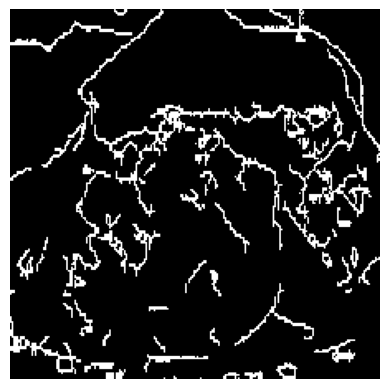

In [6]:
plt.axis(False)
t=train_ds.__getitem__(torch.randint(0,1000,(1,)))
print(t[0].shape)
plt.imshow(t[0].permute(1,2,0))
print(t[1])

In [7]:
torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [8]:
train_loader=torch.utils.data.DataLoader(train_ds,16,shuffle=True)
val_loader=torch.utils.data.DataLoader(test_ds,16,shuffle=True)

In [9]:
x,y=next(iter(train_loader))
print(x.shape)
output=torch.argmax(torch.softmax(model(x),dim=1),dim=1)
output

torch.Size([16, 3, 224, 224])


tensor([2, 2, 0, 1, 1, 1, 2, 2, 1, 0, 0, 2, 2, 2, 1, 2])

In [10]:
y

tensor([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])

In [11]:
loss_fn=nn.CrossEntropyLoss()

In [12]:
with torch.inference_mode():
    logits=model(x)
    torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),torch.argmax(y,dim=1)).sum().item()/len(logits)
    print(loss_fn(torch.squeeze(logits,dim=1),y))

tensor(1.1594)


In [13]:
model=model.to(device)

In [14]:
def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)

def train_model(model,epochs):
    optimizer=torch.optim.Adam(params=model.parameters())
    loss_fn=nn.BCEWithLogitsLoss()
    
    for i in tqdm_notebook(range(epochs)):
        train_preds=torch.tensor([])
        val_preds=torch.tensor([])
        train_actual=torch.tensor([])
        val_actual=torch.tensor([])
        
        print("\nTraining:")
        model.train()
        
        #Defining accuracy and loss for train and val data
        temp_train_accuracy=[]
        temp_val_accuracy=[]
        temp_train_loss=[]
        temp_val_loss=[]
        #temp_train_f1=[]
        #temp_val_f1=[]
    
        net_train_accuracy=0
        net_val_accuracy=0
        net_train_loss=0
        net_val_loss=0
        #net_train_f1=0
        #net_val_f1=0
        
        with tqdm_notebook(total=len(train_loader)) as pbar:
            for x,y in train_loader:
                    x=x.to(device)
                    y=y.to(device)
        
                    #Calculating model output
                    logits=model(x)
        
                    #Reseting any old gradient values
                    optimizer.zero_grad()
                    loss=loss_fn(torch.squeeze(logits,dim=1),y)
                
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    #train_preds=torch.hstack((train_preds,preds.to("cpu")))
                    #train_actual=torch.hstack((train_actual,y.to("cpu")))
                    accuracy_train=accuracy_fn(logits.type(torch.float32),torch.argmax(y,dim=1))
                    #f1_train=f1_fn(preds,y)
                    temp_train_accuracy.append(accuracy_train)
                    temp_train_loss.append(loss.item())
                    #temp_train_f1.append(f1_train.item())
                
                    #Back Propogation
                    loss.backward()
                
                    #Update Parameters
                    optimizer.step()
                
                    #Progress Bar Update
                    pbar.update(1)
            pbar.close()
        #Tensorboard & Metrics for the dataset
        net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
        net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
        #net_train_f1=sum(temp_train_f1)/len(temp_train_f1)
        #writer.add_scalar("Train Accuracy",net_train_accuracy,i)
        #writer.add_scalar("Train Loss",net_train_loss,i)
        #writer.add_scalar("Train F1 Score",net_train_f1,i)
    
        #Evaluation
        print("Testing:")
        model.eval()
    
        with tqdm_notebook(total=len(val_loader)) as pbar2:
            for x,y in val_loader:
                x=x.to(device)
                y=y.to(device)
                
                #Setting inference mode
                with torch.inference_mode():
                    logits=model(x)
                    loss=loss_fn(torch.squeeze(logits,dim=1),y.type(torch.float32))
                    
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    #val_preds=torch.hstack((val_preds,preds.to("cpu")))
                    #val_actual=torch.hstack((val_actual,y.to("cpu")))
                    accuracy_val=accuracy_fn(logits,torch.argmax(y,dim=1))
                    #f1_val=f1_fn(preds,y)
                    temp_val_accuracy.append(accuracy_val)
                    temp_val_loss.append(loss.item())
                    #temp_val_f1.append(f1_val.item())
    
                    #Progress Bar Update
                    pbar2.update(1)
            pbar2.close()
    
        #Tensorboard & Metrics for the dataset
        net_val_accuracy=sum(temp_val_accuracy)/len(temp_val_accuracy)
        net_val_loss=sum(temp_val_loss)/len(temp_val_loss)
        #net_val_f1=sum(temp_val_f1)/len(temp_val_f1)
        #writer.add_scalar("Val Accuracy",net_val_accuracy,i)
        #writer.add_scalar("Val Loss",net_val_loss,i)
        #writer.add_scalar("Val F1 Score",net_val_f1,i)

        
        print(f"\nEpoch {i+1}:\n\nTrain Accuracy: {net_train_accuracy}\n\nTrain Loss: {net_train_loss}\n\nVal Accuracy: {net_val_accuracy}\n\nVal Loss: {net_val_loss}")



In [15]:
train_model(model,10)

  0%|          | 0/10 [00:00<?, ?it/s]


Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 1:

Train Accuracy: 0.8571428571428571

Train Loss: 0.23640413029444596

Val Accuracy: 0.8561507936507936

Val Loss: 0.386452031262692

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 2:

Train Accuracy: 0.9632936507936508

Train Loss: 0.07746026350096577

Val Accuracy: 0.9781746031746031

Val Loss: 0.07873021143799026

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 3:

Train Accuracy: 0.9543650793650794

Train Loss: 0.10306981516565891

Val Accuracy: 0.9375

Val Loss: 0.1255808025746355

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 4:

Train Accuracy: 0.9742063492063492

Train Loss: 0.05447440288059177

Val Accuracy: 0.8630952380952381

Val Loss: 0.3139295973297622

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 5:

Train Accuracy: 0.9821428571428571

Train Loss: 0.04883957158456305

Val Accuracy: 0.9851190476190477

Val Loss: 0.046681663719937205

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 6:

Train Accuracy: 0.9761904761904762

Train Loss: 0.05534308774041988

Val Accuracy: 0.9811507936507936

Val Loss: 0.04773591137269423

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 7:

Train Accuracy: 0.9623015873015873

Train Loss: 0.10443071023901067

Val Accuracy: 0.9464285714285714

Val Loss: 0.0984080219197841

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 8:

Train Accuracy: 0.9781746031746031

Train Loss: 0.048131861018076066

Val Accuracy: 0.9890873015873016

Val Loss: 0.03145656391741738

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 9:

Train Accuracy: 0.9821428571428571

Train Loss: 0.052024760961695206

Val Accuracy: 0.9851190476190477

Val Loss: 0.0465735240473545

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 10:

Train Accuracy: 0.9811507936507936

Train Loss: 0.05120103285160093

Val Accuracy: 0.9880952380952381

Val Loss: 0.0364500444478518


In [16]:
x,y=next(iter(val_loader))
x=x.to(device)
y=y.to(device)

In [17]:
with torch.inference_mode():
    output=torch.argmax(torch.softmax(model(x),dim=1),dim=1)
    print(output)

tensor([0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 2, 2, 1, 0, 2, 2], device='cuda:0')


In [18]:
torch.argmax(y,dim=1)

tensor([0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 2, 2, 1, 0, 2, 2], device='cuda:0')

In [25]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 5.848MB


In [26]:
size_model = 0
for param in model.parameters():
    if param.data.is_floating_point():
        size_model += param.numel() * torch.finfo(param.data.dtype).bits
    else:
        size_model += param.numel() * torch.iinfo(param.data.dtype).bits
print(f"model size: {size_model} / bit | {size_model / 8e6:.2f} / MB")

model size: 48669792 / bit | 6.08 / MB
